#Subsección 4.2.3- Resultados-Modelo Conjunto basado en Campos Gaussianos.

*Fecha de última modificación*: 10-oct-22.

*Tesis*: Modelación de la relación entre el cerebro y el comportamiento mediante campos Gaussianos.

*Autor*: Giwon Bahg

*Modificado por*: Daniela Martínez Aguirre

*Descripción*: Código extraido y modificado del repositorio: https://github.com/MbCN-lab/gpjm y https://github.com/rodrigo-carnier/gpjm.

*Figuras*: 4.2, 4.3, 4.8 a 4.14.


In [52]:
#Librerías a utilizar
import numpy as np
!pip install gpflow==2.5.2
import gpflow
import tensorflow as tf
import time
from gpflow.utilities import ops, print_summary  

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
#Conectar con Google
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
#Importa los tiempos
time_block = np.load("/content/drive/MyDrive/Tesis/Cap4/fMRI_DATOS/time_block.npy")# Duración de cada bloque(son 4 bloques y cada bloque tiene 20 ensayos)
ts_dense = np.load("/content/drive/MyDrive/Tesis/Cap4/fMRI_DATOS/ts_dense.npy") # Time indices for behavioral data-cada medio segundo hasta 784
ts_sparse = np.load("/content/drive/MyDrive/Tesis/Cap4/fMRI_DATOS/ts_sparse.npy") # Time indices for neural data -cada segundo desde 0 hasta 783

In [55]:
#Time indices for the fixation onset (i.e., beginning of new trials)
#cada cuando empieza cada uno de los 20 ensayos
#Va de 39 en 39 hasta 744
fix_onset = np.array([  0.,  39.,  78., 117., 156., 195., 235., 274., 313., 353., 393., 431., 469., 508., 547., 587., 627., 665., 705., 744.], dtype=np.int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [56]:
#sólamente se importa un bloque de la coherencia
coh1 = np.load("/content/drive/MyDrive/Tesis/Cap4/fMRI_DATOS/coherence_scaled_013_run1.npy")

#Upscale the coherence
#la coherencia es reescalada de -1 a 1 en lugar de -.35 a .35
coh1_ext = np.column_stack([coh1, coh1]).ravel()
coh1_ext = coh1_ext[0:(len(coh1_ext)-1)]
coh1 = coh1_ext.reshape(-1,1)

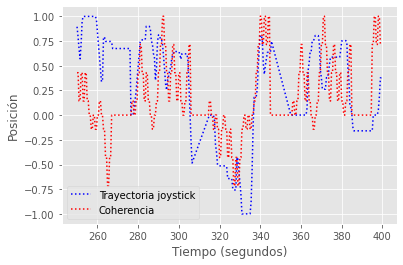

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


Text(0.5, 0, 'Tiempo (segundos)')

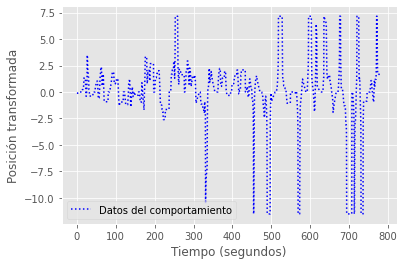

In [57]:
#Importa las trayectorias
Y_B1_ori = np.load("/content/drive/MyDrive/Tesis/Cap4/fMRI_DATOS/mouse_trajectory_centered_scaled_013_run1.npy")

#Grafica las trayectorias
#Figura 4.2a 
plt.plot(ts_dense[500:800], Y_B1_ori[500:800], linestyle=":", color="blue", label="Trayectoria joystick")
plt.plot(ts_dense[500:800], coh1[500:800], linestyle=":", color="red", label="Coherencia")
plt.ylabel("Posición")
plt.legend()
plt.xlabel("Tiempo (segundos)")
plt.show()

#Logit-transform the behavioral data
temp = Y_B1_ori/2 + 0.5
temp[np.where(temp == 0)[0]] = 1e-5
Y_B1 = np.log(temp/(1-temp))

#Logit-transform the coherence
temp = coh1/2 + 0.5
temp[np.where(temp == 0)[0]] = 1e-5
coh1_transformada= np.log(temp/(1-temp))


#Y_B0 = Y_B.T.ravel().reshape(-1,1)
Y_B1_ori = np.load("/content/drive/MyDrive/Tesis/Cap4/fMRI_DATOS/mouse_trajectory_centered_scaled_013_run1.npy")

#Figura 4.2b
plt.plot(ts_dense, Y_B1, linestyle=":", color="blue", label="Datos del comportamiento")
plt.ylabel("Posición transformada")
plt.legend()
plt.xlabel("Tiempo (segundos)")



In [58]:
#Importa datos neuronales-Sólo el primer bloque
Y_N1 = np.load("/content/drive/MyDrive/Tesis/Cap4/fMRI_DATOS/Timing013_meanTS_block1.npy")
# Y_N2 = np.load("Timing013_meanTS_block2.npy") # Not used
# Y_N3 = np.load("Timing013_meanTS_block3.npy")
# Y_N4 = np.load("Timing013_meanTS_block4.npy")

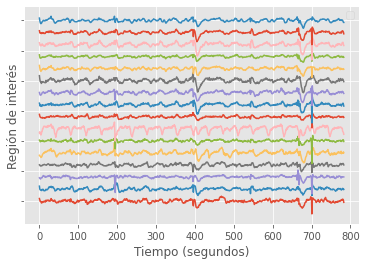

In [59]:
#Gráfica de los datos neuronales
#Figura 4.3
for i in range(16):
  plt.plot(ts_sparse, Y_N1[:,i]+i*4)

plt.yticks(visible = False) 
plt.ylabel("Región de interés")
plt.legend()
plt.xlabel("Tiempo (segundos)")
plt.show()

In [60]:
# ROI information: Not used for fitting the model.
## Coherence-related regions
ss_RC = np.array([[-54, 23, 0], [32, -23, 64], [29, -69, -41], [-48, 48, -14], [-9, -88, 26], [49, -40, 9], [7, -72, -9]], dtype = np.float64)
## Behavioral-response-related regions
ss_resp = np.array([[66, -3, 22], [54, -14, 6], [-44, -64, 11], [10, -6, 72], [-44, -3, 61], [-52, 0, 32], [60, -25, 13], [-53, -21, 10], [-10, -56, 68]], dtype = np.float64)

ss = np.vstack([ss_RC, ss_resp])

# ROI labels
label_ROI = np.array(['RC1_IFG', 'RC2_PCG', 'RC3_CRUS2', 'RC4_FP', 'RC5_OP', 'RC6_PSG', 'RC7_LG',
            'resp1_SSC1', 'resp2_AC1', 'resp3_V5', 'resp4_PMC(SFG)', 'resp5_PMC(MFG)','resp6_MC1', 'resp7_IPL', 'resp8_AC1', 'resp9_SPL'])

#Define el modelo

In [61]:
#Creación de modelo: 
#Establece las funciones kernel a utilizar
#Inicializa la variable latente
#Construye la función objetivo
class GPJMv2(gpflow.models.GPR):
    def __init__(self, Y_N, Y_B, ts_N, ts_B, n_latent, ss,
                 kern_tX = None, mean_tX = None, kern_XN = None, mean_XN = None, kern_XB = None, mean_XB = None, name=None):
        if kern_tX is None:
            #Kernel temporal variable latente
            #kern_tX = gpflow.kernels.SquaredExponential()
            kern_tX = gpflow.kernels.Matern12()
        if mean_tX is None:
            mean_tX = gpflow.mean_functions.Zero(output_dim =n_latent)
        if kern_XN is None:
            #Kernel datos neuronales
            kern_XN = gpflow.kernels.Matern12()
        if mean_XN is None:
            mean_XN = gpflow.mean_functions.Zero(output_dim = Y_N.shape[1])
        if kern_XB is None:
            #Kernel datos de comportamiento
            kern_XB = gpflow.kernels.Matern12()
        if mean_XB is None:
            mean_XB = gpflow.mean_functions.Zero(output_dim = Y_B.shape[1])
       # super().__init__(name=name)
        
        def cubic_interpolation(ts_N, Y_N, ts_B, ss):
            from scipy import interpolate
            yn_new = np.zeros((ts_B.shape[0], ss.shape[0]))
            yn_array = Y_N.reshape(ss.shape[0], ts_N.shape[0]).T
            for i in range(ss.shape[0]):
                temp = interpolate.interp1d(np.squeeze(ts_N), yn_array[:,i], kind='cubic', fill_value="extrapolate")
                yn_new[:,i] = temp(np.squeeze(ts_B))
            return yn_new
        
        def downsizing_scheme_nearest(ts_N, ts_B):
            M = np.zeros((ts_B.shape[0], ts_N.shape[0]))
            ts = np.squeeze(ts_B)
            for i in range(ts_N.shape[0]):
                argmin_idx = np.argmin(np.abs(ts - ts_N[i,0]))
                M[argmin_idx,i] = 1
            return M
        
        def HRF_filter(ts_B):
            ts = np.squeeze(ts_B)
            unit_ts = ts[ts <= 30]
            def HRFunit(t):
                from scipy.special import gamma
                a1 = 6 # b1=1
                a2 = 16 # b2=1
                c = 1./6
                part1 = t**(a1-1) * np.exp(-t) / gamma(a1)
                part2 = t**(a2-1) * np.exp(-t) / gamma(a2)
                return part1 - c * part2
            hrf = HRFunit(unit_ts)
            return(hrf)
        
        if len(ts_N) > len(ts_B):
            print("Neural: Dense / Behavioral: Sparse")
            self.ts = tf.constant(ts_N.copy())
        elif len(ts_N) < len(ts_B):
            print("Neural: Sparse / Behavioral: Dense")
            self.ts = tf.constant(ts_B.copy())
            self.ts_dense = ts_B.copy()
            self.Y_N_interp = cubic_interpolation(ts_N, Y_N, ts_B, ss)
            self.M = downsizing_scheme_nearest(ts_N, ts_B)
        
        # Data
        self.Y_N = tf.constant(Y_N.copy())
        self.Y_B = tf.constant(Y_B.copy())
        self.ts_N = tf.constant(ts_N.copy())
        self.ts_B = tf.constant(ts_B.copy())
        self.n_Nsample = Y_N.shape[0]
        self.n_Nfeature = Y_N.shape[1]
        self.n_Bsample = Y_B.shape[0]
        self.n_Bfeature = Y_B.shape[1]
        
        # latent dynamics kernel + downsizing scheme
        self.kern_tX = kern_tX
        self.mean_tX = mean_tX
        self.n_latent = n_latent
        self.N_pca = ops.pca_reduce(self.Y_N_interp, n_latent)
        self.X = gpflow.Parameter(ops.pca_reduce(self.Y_N_interp, n_latent))
        self.X_sparse = ops.pca_reduce(Y_N, n_latent)

        # Neural data kernel
        self.kern_XN = kern_XN
        self.mean_XN = mean_XN
        self.hrf = tf.constant(HRF_filter(self.ts_B))
        
        # Behavioral data kernel
        self.kern_XB = kern_XB
        self.mean_XB = mean_XB

        # Likelihood
        self.likelihood_tX = gpflow.likelihoods.Gaussian()
        self.likelihood_XN = gpflow.likelihoods.Gaussian()
        self.likelihood_XB = gpflow.likelihoods.Gaussian() # Can differ according to the model you rely on.
    
    #@gpflow.params_as_tensors
    def _build_likelihood_tX(self): # Zero-noise model is not supported by GPflow ==> Need to add an infinitesimal noise when initializing the model.
        Ktx = self.kern_tX.K(self.ts, self.ts) + tf.eye(tf.shape(self.ts)[0], dtype =tf.dtypes.float64) * self.likelihood_tX.variance
        Ltx = tf.linalg.cholesky(Ktx)
        mtx = self.mean_tX(self.ts)
        logpdf_tx = gpflow.logdensities.multivariate_normal(self.X, mtx, Ltx)
        return tf.reduce_sum(logpdf_tx)
    
    #@gpflow.params_as_tensors
    def _build_likelihood_XN(self):
        kernel_completo=self.kern_XN.K(self.X, self.X) 
        kernel_incompleto=tf.matmul(tf.transpose(self.M), tf.matmul(kernel_completo, self.M))
        Kxn = kernel_incompleto + tf.eye(self.n_Nsample, dtype =tf.dtypes.float64) * self.likelihood_XN.variance
        Lxn = tf.linalg.cholesky(Kxn)  
        mxn = self.mean_XN(self.X_sparse)
        logpdf_xn = gpflow.logdensities.multivariate_normal(self.Y_N, mxn, Lxn)
        return tf.reduce_sum(logpdf_xn)

    #@gpflow.params_as_tensors
    def _build_likelihood_XB(self):
        Kxb = self.kern_XB.K(self.X, self.X) + tf.eye(tf.shape(self.X)[0], dtype = tf.dtypes.float64) * self.likelihood_XB.variance
        Lxb = tf.linalg.cholesky(Kxb)
        mxb = self.mean_XB(self.X)
        logpdf_xb = gpflow.logdensities.multivariate_normal(self.Y_B, mxb, Lxb)
        return tf.reduce_sum(logpdf_xb)
    
    def maximum_log_likelihood_objective(self):     # 2022-02 RMC upd03: Abstract function for calculating log_likelihood now is named like this. (Was this the purpose of this function "_build_likelihood"?)
        with tf.name_scope('likelihood') as scope:  # 2022-02 RMC upd02: This is how name_scopes are defined nowaways.
            logpdf_tx = self._build_likelihood_tX()
            logpdf_xn = self._build_likelihood_XN()
            logpdf_xb = self._build_likelihood_XB()
            return tf.reduce_sum(logpdf_tx + logpdf_xn + logpdf_xb)
   

In [62]:
#Funciónes para hacer predicciones de datos nuevos

#Variable latente
def recover_latent(m, ts_new):
    import tensorflow as tf
    from numpy.linalg import inv, cholesky
    ts = m.ts.numpy()
    Kstar = m.kern_tX(ts, ts_new).numpy()
    KttI = (m.kern_tX(ts, ts) + np.eye(ts.shape[0], dtype=np.float64) * m.likelihood_tX.variance).numpy()
    X = m.X.numpy()
    L = cholesky(KttI)
    return Kstar.T.dot(inv(L.T).dot((inv(L)).dot(X)))

#Datos neuronales
def recover_neural(m, ts_new):
    import tensorflow as tf
    from numpy.linalg import inv, cholesky
    #m=test
    ts_N =m.ts_N.numpy()
    Y_N = m.Y_N.numpy()
    X_new = recover_latent(m, ts_new)
    X = m.X.numpy()[train_index % 2 == 0]
    Kstar=m.kern_XN(X, X_new).numpy()
    KttI = (m.kern_XN(X, X) + np.eye(len(tss_train), dtype = np.float64) * m.likelihood_XN.variance).numpy()
    L = cholesky(KttI)
    fmean = Kstar.T.dot(inv(L.T).dot((inv(L)).dot(Y_N)))
    v = inv(L).dot(Kstar)
    Vstar = m.kern_XN(X_new, X_new).numpy() - v.T.dot(v)+np.eye(X_new.shape[0], dtype = np.float64) * m.likelihood_XN.variance
    sd = np.sqrt(np.diag(Vstar))
    return fmean, Vstar, sd

#Datos de comportamiento
def recover_behavioral(m, ts_new):
    import tensorflow as tf
    from numpy.linalg import inv, cholesky
    X_new = recover_latent(m, ts_new)
    X = m.X.numpy()
    Kstar = m.kern_XB(X, X_new).numpy()
    KttI = (m.kern_XB(X, X) + np.eye(len(tsd_train), dtype = np.float64) * m.likelihood_XB.variance).numpy()
    Y_B = m.Y_B.numpy()
    L = cholesky(KttI)
    fmean = Kstar.T.dot(inv(L.T).dot((inv(L)).dot(Y_B)))
    v = inv(L).dot(Kstar)
    Vstar = m.kern_XB(X_new, X_new).numpy() - v.T.dot(v)+np.eye(X_new.shape[0], dtype = np.float64) * m.likelihood_XB.variance
    sd= np.sqrt(np.diag(Vstar))
    ci95 = np.column_stack([fmean - 1.96 * np.sqrt(np.diag(Vstar)).reshape(-1,1), fmean + 1.96 * np.sqrt(np.diag(Vstar)).reshape(-1,1)])
    return fmean, Vstar, ci95


#Ajuste del modelo

In [63]:
#Centrado y escalado de los datos
#Hacemos una copia de los datos
Y_N1_es=Y_N1.copy()
Y_B1_es=Y_B1.copy()

#Estandarizamos los datos neuronales
Y_N1_es-= np.mean(Y_N1_es, axis=0)
Y_N1_es /= np.std(Y_N1_es, axis=0)

#Estandarizamos los datos de comportamiento
Y_B1_es-= np.mean(Y_B1_es, axis=0)
Y_B1_es /= np.std(Y_B1_es, axis=0)

#Separamos en entrenamiento y prueba
from sklearn.model_selection import train_test_split
z=np.arange(len(ts_dense))
train_index, test_index=train_test_split(z,  train_size=.9, random_state=1, shuffle=True)
train_index=np.sort(train_index)
test_index=np.sort(test_index)

tsd_train, tsd_test = ts_dense[train_index,:], ts_dense[test_index,:]
tss_train, tss_test = ts_dense[train_index[train_index % 2 == 0],:], ts_dense[test_index[test_index % 2 == 0] ,:]

Y_N1_train=Y_N1_es[tss_train.astype(int)[:,0]]
Y_B1_train=Y_B1_es[train_index, :]
Y_N1_test=Y_N1_es[tss_test.astype(int)[:,0]]
Y_B1_test=Y_B1_es[test_index, :]


In [64]:
#Definimos el modelo

#Dimensión de la variable latente
n_latent=4
#Guarda el modelo
test= GPJMv2(Y_N1_train ,Y_B1_train, tss_train, tsd_train, n_latent, ss)
#test.likelihood_tX.variance = 1e-6
#gpflow.set_trainable(test.likelihood_tX, False)

#Resumen del modelo
test

Neural: Sparse / Behavioral: Dense


name,class,transform,prior,trainable,shape,dtype,value
GPJMv2.kern_tX.variance,Parameter,Softplus,,True,(),float64,1.0
GPJMv2.kern_tX.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPJMv2.X,Parameter,Identity,,True,"(1410, 4)",float64,"[[-0.45042212, 0.02465187, 2.25638391..."
GPJMv2.kern_XN.variance,Parameter,Softplus,,True,(),float64,1.0
GPJMv2.kern_XN.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPJMv2.kern_XB.variance,Parameter,Softplus,,True,(),float64,1.0
GPJMv2.kern_XB.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPJMv2.likelihood_tX.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
GPJMv2.likelihood_XN.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
GPJMv2.likelihood_XB.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


In [65]:
#Establezcamos el método de optimización
@tf.function
def optimisation_step():
    adam_opt.minimize(test.training_loss, test.trainable_variables)

In [66]:
#Condiciones de optimización y corrida
#Correr con 700 iteraciones
#Guarda los resultados cada 20 iteraciones
max_iter = 700
record_step = 20
X_storage = np.zeros((test.X.shape[0], test.X.shape[1], (max_iter+1)))
llk_storage = np.zeros(max_iter+1)

#Tasa de aprendizaje
learning_rate_vec_temp = 0.2/np.sqrt(np.arange(max_iter)+1)
learning_rate_vec = np.zeros_like(learning_rate_vec_temp)
for i in range(len(learning_rate_vec_temp)):
    learning_rate_vec[i] = learning_rate_vec_temp[int(np.floor(i/record_step))]

#Optimización

for iter in range(max_iter):
  l = learning_rate_vec[iter]
  adam_opt = tf.optimizers.Adam(l)
  optimisation_step()

  if max_iter % record_step== 0 and iter > 0:
    print(f"Epoch {iter} - Loss: {test.training_loss().numpy() : .4f}")

Epoch 1 - Loss:  24577.9633
Epoch 2 - Loss:  23374.9014
Epoch 3 - Loss:  22265.0092
Epoch 4 - Loss:  21221.4004
Epoch 5 - Loss:  20217.2138
Epoch 6 - Loss:  19236.3136
Epoch 7 - Loss:  18254.7711
Epoch 8 - Loss:  17268.8405
Epoch 9 - Loss:  16276.9143
Epoch 10 - Loss:  15330.5308
Epoch 11 - Loss:  14465.9493
Epoch 12 - Loss:  13639.1758
Epoch 13 - Loss:  12793.2012
Epoch 14 - Loss:  11978.1074
Epoch 15 - Loss:  11179.8561
Epoch 16 - Loss:  10503.8356
Epoch 17 - Loss:  9796.7198
Epoch 18 - Loss:  9225.6064
Epoch 19 - Loss:  8644.4702
Epoch 20 - Loss:  8106.2773
Epoch 21 - Loss:  7563.7983
Epoch 22 - Loss:  7031.6094
Epoch 23 - Loss:  6590.7693
Epoch 24 - Loss:  6163.4379
Epoch 25 - Loss:  5752.4941
Epoch 26 - Loss:  5323.3339
Epoch 27 - Loss:  4996.9061
Epoch 28 - Loss:  4684.6744
Epoch 29 - Loss:  4375.5585
Epoch 30 - Loss:  4034.2617
Epoch 31 - Loss:  3836.6539
Epoch 32 - Loss:  3611.1326
Epoch 33 - Loss:  3393.3870
Epoch 34 - Loss:  3212.6175
Epoch 35 - Loss:  3029.8371
Epoch 36 - Lo

#Estimación de la variable latente

Text(0, 0.5, 'Value')

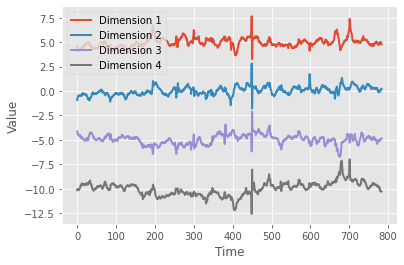

In [67]:
#Gráfica de la variable latente estimada
#Figura 4.8

X_new=recover_latent(test, ts_dense)
plt.plot(ts_dense, X_new[:,0]+5, label = "Dimension 1", linewidth=2)
plt.plot(ts_dense, X_new[:,1], label = "Dimension 2", linewidth=2)
plt.plot(ts_dense, X_new[:,2]-5, label = "Dimension 3", linewidth=2)
plt.plot(ts_dense, X_new[:,3]-10, label = "Dimension 4", linewidth=2)

plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
#plt.title("Dinámica latente-4 dimensiones")

In [68]:
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline, CubicSpline

latent4 = test.X # Latent dynamics

l4sg31 = np.zeros_like(latent4)
l4sg51 = np.zeros_like(latent4)
for i in range(latent4.shape[1]):
    l4sg31[:,i] = savgol_filter(latent4[:,i], 31, 3) # Window size = 31
    l4sg51[:,i] = savgol_filter(latent4[:,i], 51, 3) # Window size = 51

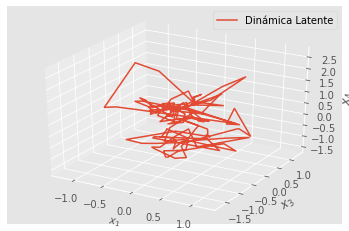

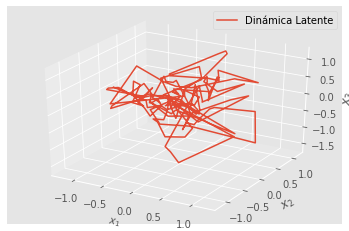

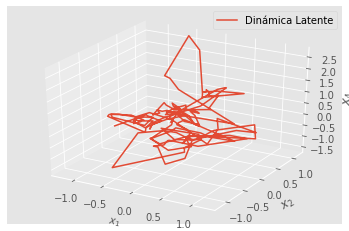

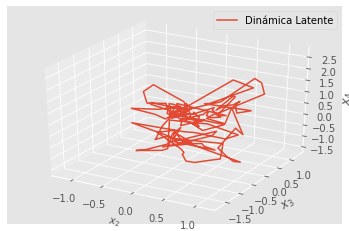

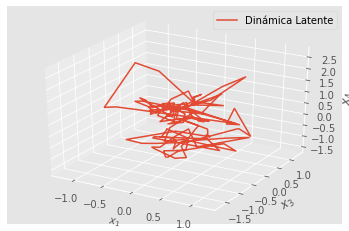

In [69]:
#Gráficas tridimensionales de la variable latente.
#Figura 4.9

#Gráfica tridimensional: Dimensiones 1, 2 y 3
fig = plt.figure()
z = np.linspace(0, 783, 100)
X_new = recover_latent(test, tsd_test)

ax = plt.axes(projection='3d')
ax.plot3D(X_new[:,0], X_new[:,1], X_new[:,2], label="Dinámica Latente")
ax.legend()

ax.set_xlabel('$x_1$', fontsize=10, rotation=150)
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
fig


#Gráfica tridimensional: Dimensiones 1, 2 y 4
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(X_new[:,0], X_new[:,1], X_new[:,3], label="Dinámica Latente")
ax.legend()


ax.set_xlabel('$x_1$', fontsize=10, rotation=150)
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_4$')
fig

#Gráfica tridimensional: Dimensiones 2, 3 y 4
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(X_new[:,1], X_new[:,2], X_new[:,3], label="Dinámica Latente")
ax.legend()

ax.set_xlabel('$x_2$', fontsize=10, rotation=150)
ax.set_ylabel('$x_3$')
ax.set_zlabel('$x_4$')
fig

#Gráfica tridimensional: Dimensiones 1, 3 y 4
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(X_new[:,0], X_new[:,2], X_new[:,3], label="Dinámica Latente")
ax.legend()

ax.set_xlabel('$x_1$', fontsize=10, rotation=150)
ax.set_ylabel('$x_3$')
ax.set_zlabel('$x_4$')
fig

#Estimación de los datos neuronales

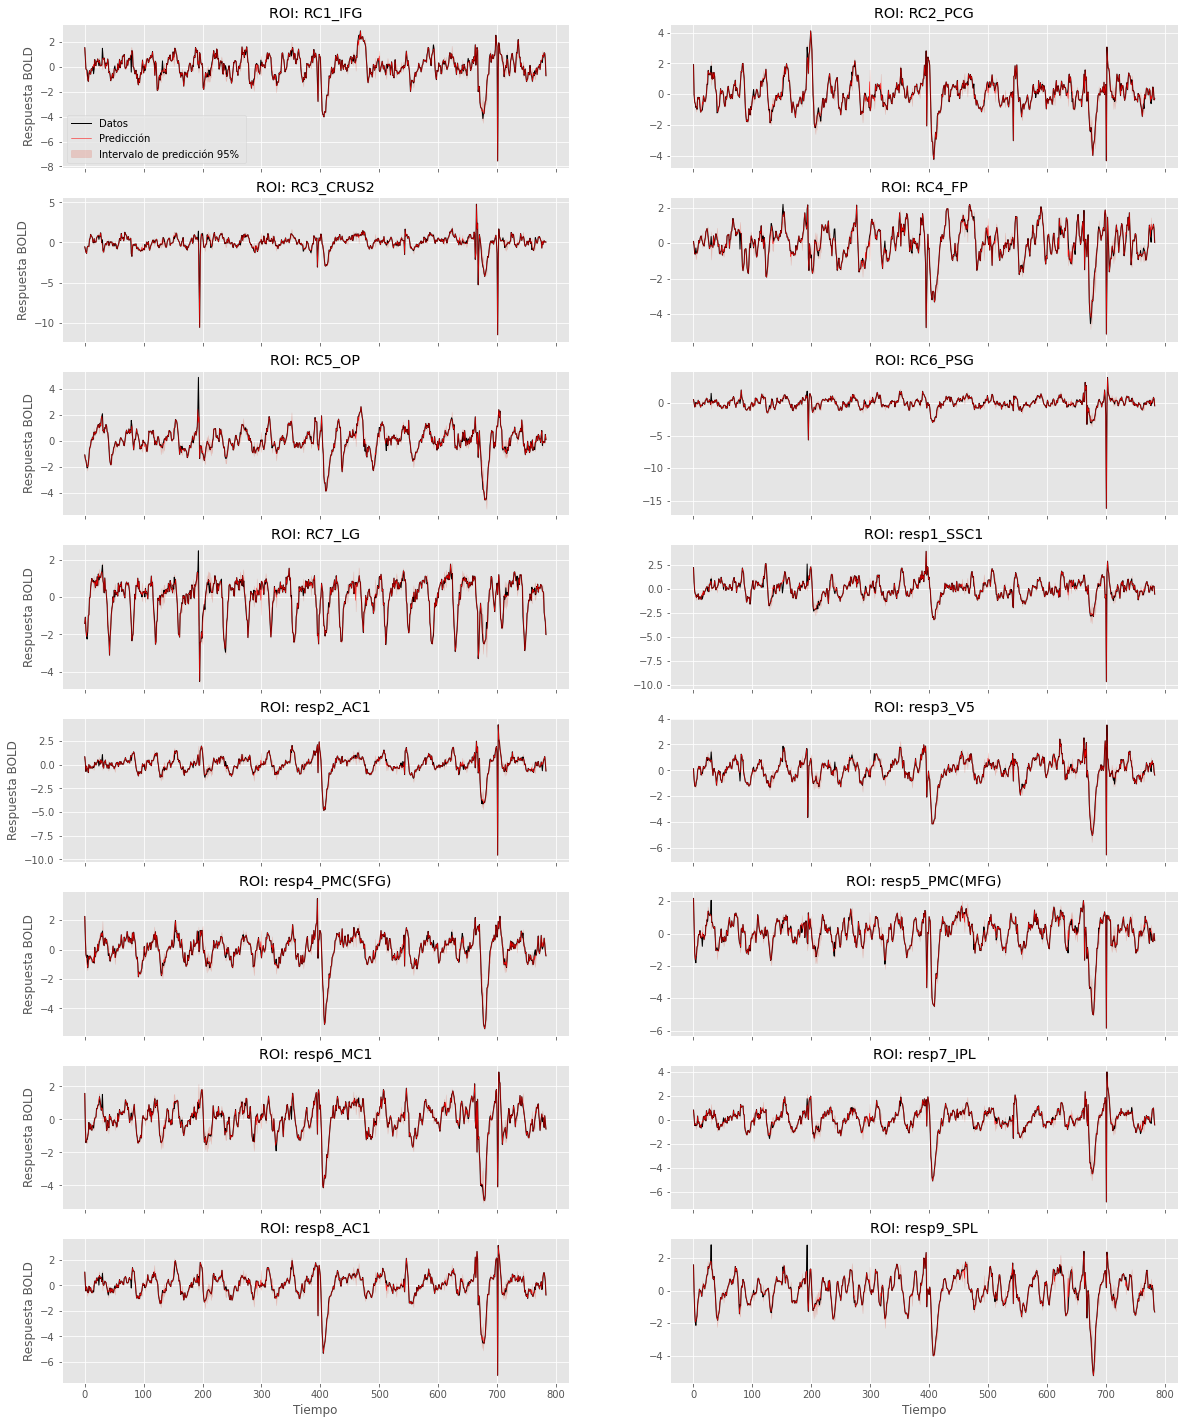

In [70]:
#Gráficas de los datos neuronales
#Figura 4.10
yhat_arr, yhat_v, yhat_sd = recover_neural(test, ts_sparse)
fig, axs = plt.subplots(8, 2, figsize=(20, 25), sharex=True)
for r in range(8):
    for c in range(2):
        voxel_idx = c+r*2
        if voxel_idx < 16:
            axs[r,c].plot(ts_sparse, Y_N1_es[:,voxel_idx], c="k", label="Datos", linewidth=1)
            axs[r,c].plot(ts_sparse, yhat_arr[:,voxel_idx], c="r", label = "Predicción",linewidth=.5 )
            axs[r,c].fill_between(ts_sparse[:,0], yhat_arr[:,voxel_idx] - 1.96 * yhat_sd,  yhat_arr[:,voxel_idx] + 1.96 * yhat_sd, color="C0", alpha=0.2,label="Intervalo de predicción 95% ")
            #axs[r,c].plot(ts_sparse, yhat_arr[:,voxel_idx] - 1.96 * yhat_sd, c="orange",linestyle=":", label="Intervalo 95% de confianza")
            #axs[r,c].plot(ts_sparse, yhat_arr[:,voxel_idx] + 1.96 * yhat_sd, c="orange",linestyle=":")
            axs[r,c].set_title("ROI: "+label_ROI[voxel_idx])
        if r == 0 and c == 0:
            axs[r,c].legend()
        if r == 7:
            axs[r,c].set_xlabel("Tiempo")
        if c==0:
            axs[r,c].set_ylabel("Respuesta BOLD")

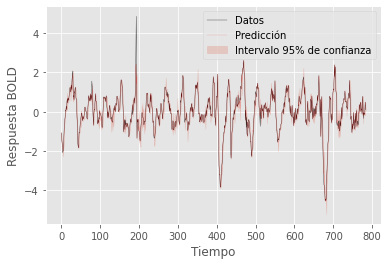

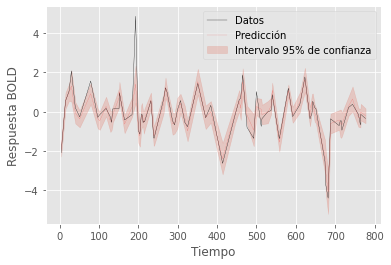

In [71]:
#Gráficas de los datos neuronales: Voxel 5
#Figura 4.12

#Datos totales
voxel_idx=4
yhat_arr, yhat_v, yhat_sd = recover_neural(test, ts_sparse)
plt.plot(ts_sparse, Y_N1_es[:,voxel_idx], c="k", label="Datos", linewidth=.3)
plt.plot(ts_sparse, yhat_arr[:,voxel_idx], c="r", label = "Predicción",linewidth=.1 )
plt.fill_between(ts_sparse[:,0], yhat_arr[:,voxel_idx] - 1.96 * yhat_sd,  yhat_arr[:,voxel_idx] + 1.96 * yhat_sd,label="Intervalo 95% de confianza",  color="C0", alpha=0.2,)
plt.xlabel("Tiempo")
plt.ylabel("Respuesta BOLD")
plt.legend()
plt.show()

#Datos de prueba
yhat_arr, yhat_v, yhat_sd = recover_neural(test, tss_test)
plt.plot(tss_test, Y_N1_test[:,voxel_idx], c="k", label="Datos", linewidth=.3)
plt.plot(tss_test, yhat_arr[:,voxel_idx], c="r", label = "Predicción",linewidth=.1 )
plt.fill_between(tss_test[:,0], yhat_arr[:,voxel_idx] - 1.96 * yhat_sd,  yhat_arr[:,voxel_idx] + 1.96 * yhat_sd, label="Intervalo 95% de confianza",color="C0", alpha=0.2,)
plt.xlabel("Tiempo")
plt.legend()
plt.ylabel("Respuesta BOLD")
#plt.title("ROI Núm. 1-Datos test")
plt.show()


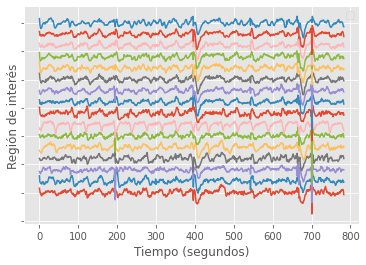

In [72]:
#Estimación de los datos neuronales
#Figura 4.13
yhat_arr, yhat_v, yhat_sd = recover_neural(test, ts_sparse)
for i in range(16):
  plt.plot(ts_sparse, yhat_arr[:,i]+i*4)
plt.yticks(visible = False) 
plt.ylabel("Región de interés")
plt.legend()
#plt.grid(color='w', ls = '-.', lw = 0.25)
plt.xlabel("Tiempo (segundos)")
plt.show()


#Estimación de los datos de comportamiento

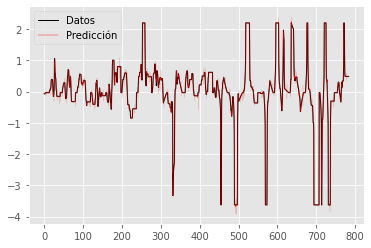

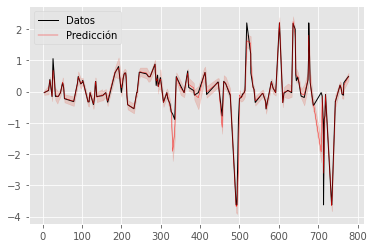

In [73]:
#Gráficas de los datos de comportamiento
#Figura 4.14
bmean, bV, bci = recover_behavioral(test, ts_dense)

plt.plot(ts_dense, Y_B1_es.ravel(), c="k", linewidth = 1, label="Datos")
plt.plot(ts_dense, bmean.ravel(), c="r", label = "Predicción", linewidth=.4)
plt.fill_between(
    ts_dense[:,0],
     bci[:,0],
    bci[:,1],
    color="C0",
    alpha=0.2
)
plt.legend()
#plt.title("Datos del comportamiento- Total datos")
plt.show()


bmean, bV, bci = recover_behavioral(test, tsd_test)
#plt.figure(figsize=(7,4))
plt.plot(tsd_test, Y_B1_test.ravel(), c="k", linewidth = 1, label="Datos")
plt.plot(tsd_test, bmean.ravel(), c="r", label = "Predicción", linewidth=.4)
plt.fill_between(
    tsd_test[:,0],
     bci[:,0],
    bci[:,1],
    color="C0",
    alpha=0.2
)
plt.legend()
#plt.title("Datos del comportamiento- Datos test")
plt.show()


Análisis de los errores

In [74]:
#Análisis

#Tabla 4.7
#% de datos entrenamiento dentro de las bandas de confianza
yhat_arr_test, yhat_v_test, yhat_sd_test = recover_neural(test, tss_test)
total=np.zeros((16))
for i in range(16):
  for j in range(len(tss_test)):
    con1=yhat_arr_test[j,i] - 1.96 * yhat_sd_test[j]
    con2=yhat_arr_test[j,i] + 1.96 * yhat_sd_test[j]
    if(con1< Y_N1_test[j,i] and  Y_N1_test[j,i]<con2):
      total[i]=total[i]+1
total/len(tss_test)

#% de datos entrenamiento dentro de las bandas de confianza
ybhat_arr_test, ybhat_v_test, ybhat_sd_test = recover_behavioral(test, tsd_test)
total2=np.zeros((1))
for j in range(len(tsd_test)):
  con1=ybhat_sd_test[j,1]
  con2=ybhat_sd_test[j,0]
  if(con2< Y_B1_test[j,0] and  Y_B1_test[j,0]<con1):
    total2=total2+1

#Cálculo del error cuadrático médio
k1=len(tss_test)
k2=len(tsd_test)
k3=16

ECM=(np.sum((yhat_arr_test-Y_N1_test)**2) +np.sum((ybhat_arr_test-Y_B1_test)**2))/(k1*k3+k2)
ECM2=np.sum((yhat_arr_test-Y_N1_test)**2)/(k1*k3)
ECM3=np.sum((ybhat_arr_test-Y_B1_test)**2)/k2

lxn=tf.linalg.cholesky(ybhat_v_test)
log1=gpflow.logdensities.multivariate_normal(Y_B1_test, ybhat_arr_test, lxn).numpy()

lxn=tf.linalg.cholesky(yhat_v_test)
log2=np.sum(gpflow.logdensities.multivariate_normal(Y_N1_test, yhat_arr_test, lxn).numpy())

log=log1+log2

print("El error cuadrático medio datos neuronales es:")
print(ECM2)
print("El error cuadrático medio datos comportamiento es:")
print(ECM3)
print("El error cuadrático medio final es:")
print(ECM)
print("La log probabilidad de los datos neuronales es:")
print(log2)
print("La log probabilidad de los datos comportamiento es:")
print(log1)
print("La log probabilidad de los datos total es:")
print(log)
print("% datos de neuronales en las bandas de confianza por ROI:")
print(total/len(tss_test))
print("% datos de neuronales en las bandas de confianza:")
print(np.sum(total)/(len(tss_test)*16))
print("% datos de comportamiento en las bandas de confianza:")
print((total2)/(len(tsd_test)))
print("% datos totales en las bandas de confianza:")
print((np.sum(total)+total2)/((len(tss_test)*16)+len(tsd_test)))


El error cuadrático medio datos neuronales es:
0.14783309692197805
El error cuadrático medio datos comportamiento es:
0.06571810369113963
El error cuadrático medio final es:
0.13886159105055032
La log probabilidad de los datos neuronales es:
-677.234733608558
La log probabilidad de los datos comportamiento es:
[-58.08640825]
La log probabilidad de los datos total es:
[-735.32114186]
% datos de neuronales en las bandas de confianza por ROI:
[0.8125 0.8125 0.9    0.825  0.9125 0.9125 0.875  0.775  0.8625 0.9125
 0.85   0.85   0.925  0.9    0.9    0.9   ]
% datos de neuronales en las bandas de confianza:
0.8703125
% datos de comportamiento en las bandas de confianza:
[0.9044586]
% datos totales en las bandas de confianza:
[0.87404315]


In [75]:
#Error cuadrático medio por región de interes
z=np.arange(1,17)
ECM_region=np.sum((yhat_arr_test-Y_N1_test)**2,0)/k1
log_region=gpflow.logdensities.multivariate_normal(Y_N1_test, yhat_arr_test, lxn).numpy()

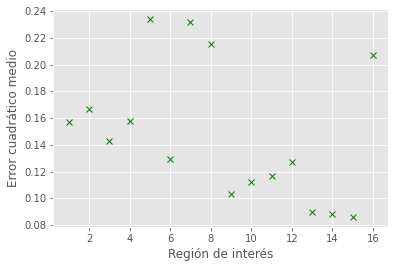

In [76]:
#Gráfica del error cuadrático medio por región de interés
#Figura 4.11a
plt.plot(z, ECM_region, 'go', marker='x')
plt.xlabel("Región de interés")
plt.ylabel("Error cuadrático medio")
plt.show()

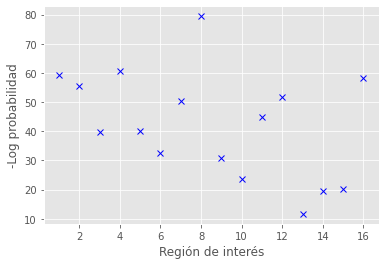

In [77]:
#Gráfica de  la log verosimilitud por región de interés
#Figura 4.11b
plt.plot(z, -log_region, 'bo', marker='x')
plt.xlabel("Región de interés")
plt.ylabel("-Log probabilidad")
plt.show()

In [78]:
#Estimaciones de los hiperparámetros
#Tabla 4.6
test

name,class,transform,prior,trainable,shape,dtype,value
GPJMv2.kern_tX.variance,Parameter,Softplus,,True,(),float64,0.31799783243012536
GPJMv2.kern_tX.lengthscales,Parameter,Softplus,,True,(),float64,21.005667161488173
GPJMv2.X,Parameter,Identity,,True,"(1410, 4)",float64,"[[-0.39764362, -0.91949215, 0.86217618..."
GPJMv2.kern_XN.variance,Parameter,Softplus,,True,(),float64,8.917343031124064
GPJMv2.kern_XN.lengthscales,Parameter,Softplus,,True,(),float64,16.105779263887026
GPJMv2.kern_XB.variance,Parameter,Softplus,,True,(),float64,1.8099997934796639
GPJMv2.kern_XB.lengthscales,Parameter,Softplus,,True,(),float64,19.808494902927304
GPJMv2.likelihood_tX.variance,Parameter,Softplus + Shift,,True,(),float64,6.906795515152101e-06
GPJMv2.likelihood_XN.variance,Parameter,Softplus + Shift,,True,(),float64,0.00014840088993716983
GPJMv2.likelihood_XB.variance,Parameter,Softplus + Shift,,True,(),float64,1.0023262728256214e-05


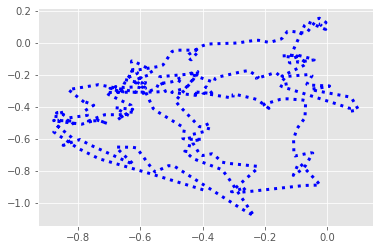

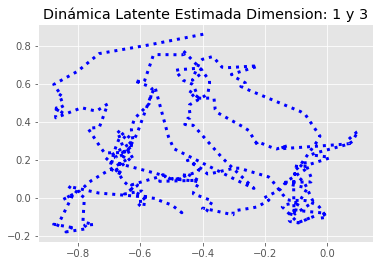

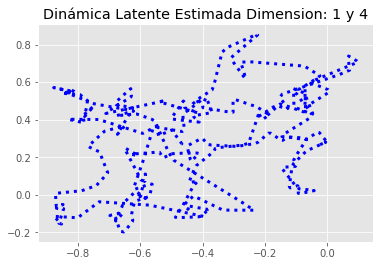

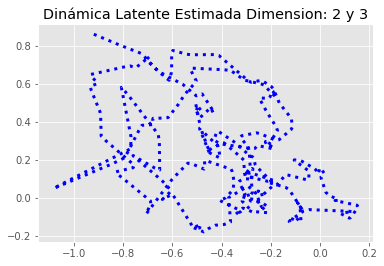

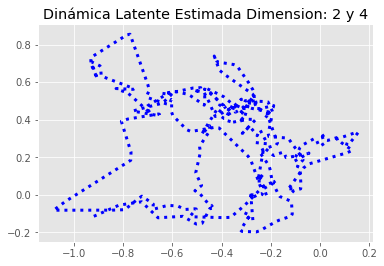

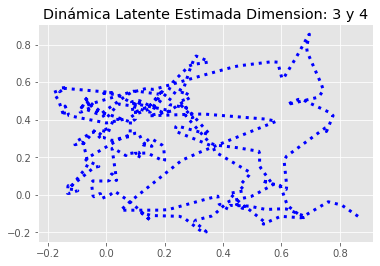

In [79]:
#Gráficas de las variables latentes a dos dimensiones
import matplotlib.colors as colors
import matplotlib.cm as cm
ts_long = np.linspace(0,100,1000)
ts_long.shape

# Extract the estimated dynamics
latent2 = test.X

# Two-dimensional plots
latent2_0 = np.interp(ts_long, tsd_train.ravel(), latent2[:,0])
latent2_1 = np.interp(ts_long, tsd_train.ravel(), latent2[:,1])
latent2_2 = np.interp(ts_long, tsd_train.ravel(), latent2[:,2])
latent2_3 = np.interp(ts_long, tsd_train.ravel(), latent2[:,3])

plt.plot(latent2_0, latent2_1, c="b", linestyle=":", linewidth=3)
#plt.title("Dinámica Latente Estimada Dimension: 1 y 2")
plt.show()

plt.plot(latent2_0, latent2_2, c="b", linestyle=":", linewidth=3)
plt.title("Dinámica Latente Estimada Dimension: 1 y 3")
plt.show()


plt.plot(latent2_0, latent2_3, c="b", linestyle=":", linewidth=3)
plt.title("Dinámica Latente Estimada Dimension: 1 y 4")
plt.show()


plt.plot(latent2_1, latent2_2, c="b", linestyle=":", linewidth=3)
plt.title("Dinámica Latente Estimada Dimension: 2 y 3")
plt.show()

plt.plot(latent2_1, latent2_3, c="b", linestyle=":", linewidth=3)
plt.title("Dinámica Latente Estimada Dimension: 2 y 4")
plt.show()

plt.plot(latent2_2, latent2_3, c="b", linestyle=":", linewidth=3)
plt.title("Dinámica Latente Estimada Dimension: 3 y 4")
plt.show()



